# Movies feature graph

In [1]:
# Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import ast

# Constants
ML_DATA_PATH = '../data/ml-100k-convert/'
GENERATED_PATH = '../generated/'
GRAPH_PATH = '../graphs/'

%matplotlib inline

In [2]:
movies = pd.read_csv(GENERATED_PATH+'final_movies.csv')

## Combining the tmdb and MovieLens dataset

<b>WE CAN SKIP THIS, CREATES THE 'FINAL_MOVIES.CSV' FILE </b>

In [45]:
# Load imdb datasets
tmdb_movies = pd.read_csv('datasets/tmdb_5000_movies.csv', delimiter=',') 
tmdb_movies_cast = pd.read_csv('datasets/tmdb_5000_credits.csv', delimiter=',') 

# Drop some columns and change index
tmdb_movies = tmdb_movies.drop(columns=["homepage", "status", "tagline", "overview", "original_title"])
tmdb_movies.head()

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",John Carter,6.1,2124


In [46]:
# Load MovieLens dataset
ML_links = pd.read_csv('datasets/ml-latest/links.csv', delimiter=',')
#ML_ratings = pd.read_csv('datasets/ml-latest-small/ratings.csv', delimiter=',') 
ML_links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
58093,193876,38566,78251.0
58094,193878,1754787,87558.0
58095,193880,5847740,422666.0
58096,193882,4453756,454439.0


We can only use the movies that are in the TMDB_5000, ml-latest and ml-100k datasets, 

In [47]:
# Load links of the movies to use
movie_links = pd.read_csv('datasets/ml_links.csv')
movie_links.head()

,ML-100k-convertId,ML-latestId
0,1,1
1,2,10
2,3,18
3,4,21
4,5,22


In [81]:
# Join ML_links and the total links
movies = ML_links.merge(movie_links, left_on="movieId", right_on="ML-latestId")
# Create a merge of the movies in tmdb 5000 and movielens
movies = tmdb_movies.merge(movies, left_on="id", right_on="tmdbId")
movies.head()

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,movieId,imdbId,tmdbId,ML-100k-convertId,ML-latestId
0,200000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",597,"[{""id"": 2580, ""name"": ""shipwreck""}, {""id"": 298...",en,100.025899,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-11-18,1845034188,194.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Titanic,7.5,7562,1721,120338,597.0,313,1721
1,175000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",9804,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 331, ""na...",en,44.640292,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-07-28,264218220,135.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Waterworld,5.9,992,208,114898,9804.0,554,208
2,125000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",415,"[{""id"": 848, ""name"": ""double life""}, {""id"": 84...",en,50.073575,"[{""name"": ""PolyGram Filmed Entertainment"", ""id...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1997-06-20,238207122,125.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Batman & Robin,4.2,1418,1562,118688,415.0,254,1562
3,116000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",9619,"[{""id"": 720, ""name"": ""helicopter""}, {""id"": 141...",en,16.904440,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-02-07,178127760,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Dante's Peak,5.7,428,1438,118928,9619.0,323,1438
4,110000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",714,"[{""id"": 212, ""name"": ""london england""}, {""id"":...",en,42.887121,"[{""name"": ""Eon Productions"", ""id"": 7576}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1997-12-11,333011068,119.0,"[{""iso_639_1"": ""de"", ""name"": ""Deutsch""}, {""iso...",Tomorrow Never Dies,6.0,925,1722,120347,714.0,751,1722


In [82]:
# id is tmdbId and ML-latestId is movieId
# From now on use tmdbId as the real ID
movies.drop(columns=["tmdbId", "movieId"], inplace=True)
movies.to_csv("datasets/final_movies.csv", index=False)

In [57]:
movies.shape

(480, 18)

The combined dataset of the ML_latest, ML_100k and tmdb contains 480 movies

## Feature networks

There are many possible networds we could create from the features. 

We will explore and possibly make the following graphs:
* genres
* keywords
* revenue & budget
* language
* production company


In [3]:
def strdict_to_column(strdict, name):
    """
    Converts a dict (in string format) to a list of the values
    e.g. [{"id": 18, "name": "Drama"}, {"id": 10749, "Action"}] -> ["Drama", "Action"]
    """
    list_dicts = strdict.apply(lambda x: ast.literal_eval(x))
    # Convert list of dicts to list of keywords/genres
    _list = list_dicts.apply(lambda x: [d['name'] for d in x ])
    df = pd.DataFrame(_list)
    df = df.explode(name)
    df['count'] = 1
    # Pivot so 'name' becomes columns
    df = df.pivot(columns=name, values='count').fillna(0)
    return df

In [4]:
def distance_to_weight():
    # Let us use the Gaussian function
    kernel_width = distances.mean()
    weights_list = np.exp(-distances**2 / kernel_width**2)

In [5]:
def epsilon_similarity_graph(distances: np.ndarray, alpha=1, epsilon=0):
    """ X (n x n): distance matrix
        alpha (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    X = distances.copy()
    X[X > epsilon] = np.inf
    adjacency = np.exp( - X ** 2 / alpha)
    np.fill_diagonal(adjacency, 0)
    return adjacency

### Genre network

Here, we use the item dataset of ml-100k-convert

In [6]:
movie_genres = movies["genres"]
movie_genres_matrix = strdict_to_column(movie_genres, "genres")
genres = list(movie_genres_matrix.columns)

In [7]:
movie_genres_matrix.head()

genres,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


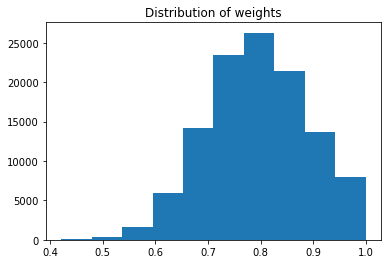

In [8]:
# 1 means completely similar
genre_distances = 1-pdist(movie_genres_matrix, 'hamming')
plt.hist(genre_distances)
plt.title('Distribution of weights')
plt.show()

In [9]:
unique, counts = np.unique(genre_distances, return_counts=True)
dict(zip(unique, counts))

{0.42105263157894735: 2,
 0.4736842105263158: 44,
 0.5263157894736843: 326,
 0.5789473684210527: 1637,
 0.631578947368421: 5906,
 0.6842105263157895: 14226,
 0.736842105263158: 23458,
 0.7894736842105263: 26272,
 0.8421052631578947: 21439,
 0.8947368421052632: 13624,
 0.9473684210526316: 6433,
 1.0: 1593}

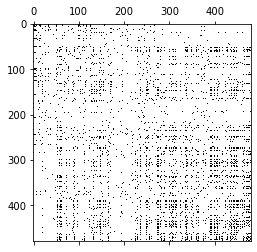

In [10]:
# Connected when all genres the same or one difference
genre_adjacency = squareform(np.where(genre_distances>0.90,1,0))
plt.spy(genre_adjacency)
plt.show()

In [11]:
# Add labels for visualisation in Gephi
movie_genres_matrix['label'] = movie_genres_matrix.apply(lambda x: [genre for genre in genres if x[genre] != 0], axis=1)
movie_genres_matrix['label'] = movie_genres_matrix.apply(lambda x: {0: '-'.join(x['label'])}, axis=1)
movie_genres_matrix['label']

0         {0: 'Drama-Romance-Thriller'}
1               {0: 'Action-Adventure'}
2           {0: 'Action-Crime-Fantasy'}
3      {0: 'Action-Adventure-Thriller'}
4      {0: 'Action-Adventure-Thriller'}
                     ...               
475               {0: 'Comedy-Romance'}
476                 {0: 'Comedy-Drama'}
477         {0: 'Comedy-Drama-Romance'}
478                       {0: 'Comedy'}
479                 {0: 'Comedy-Drama'}
Name: label, Length: 480, dtype: object

In [12]:
# Export for use in Gephi
graph = nx.from_numpy_array(genre_adjacency)
nx.set_node_attributes(graph, movie_genres_matrix['label'])
nx.write_gexf(graph, GRAPH_PATH+'movie_genres.gexf')

### Keywords network

In [32]:
movie_keywords = movies["keywords"]
movie_keywords_matrix = strdict_to_column(movie_keywords, "keywords")
keywords = list(movie_keywords_matrix.columns)

In [25]:
movie_keywords_matrix.head()

keywords,NaN,15th century,17th century,18th century,1910s,1930s,1940s,1950s,1960s,1970s,...,wyoming,x-ray,x-ray vision,xenomorph,yellow press,young heroes,yuppie,zombie,flipping coin,nightgown
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
movie_keywords_matrix.iloc[0]

keywords
NaN               0.0
15th century      0.0
17th century      0.0
18th century      0.0
1910s             1.0
                 ... 
young heroes      0.0
yuppie            0.0
zombie            0.0
 flipping coin    0.0
 nightgown        0.0
Name: 0, Length: 2706, dtype: float64

In [27]:
keyword_distances = 1-pdist(movie_keywords_matrix,'jaccard')

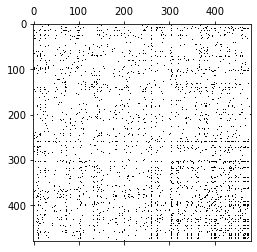

In [28]:
keyword_adjacency = squareform(np.where(keyword_distances> 0 , 1 , 0))
plt.spy(keyword_adjacency)
plt.show()

In [29]:
distance = np.empty([movie_keywords_matrix.shape[0]]*2)
for i in range(movie_keywords_matrix.shape[0]):
    for j in range(movie_keywords_matrix.shape[0]):
        distance[i,j] = np.linalg.norm(movie_keywords_matrix.iloc[j] - movie_keywords_matrix.iloc[i])
distance.shape

(480, 480)

In [30]:
mean_distance = distance.mean()
mean_distance

4.3841276759766945

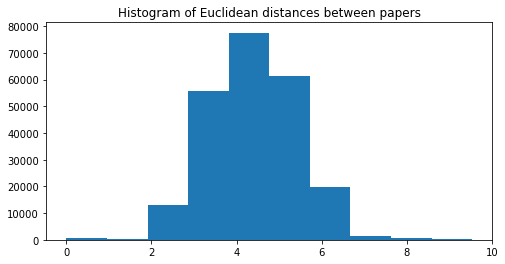

In [31]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());

In [21]:
threshold = mean_distance
A_feature = np.zeros(distance.shape)
A_feature[distance > threshold] = 1
movie_keywords_matrix = pd.DataFrame(A_feature)

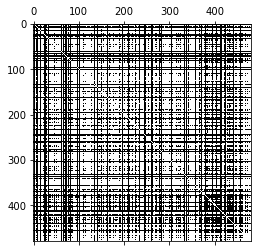

In [22]:
plt.spy(movie_keywords_matrix)
plt.show()

In [33]:
# Add labels for visualisation in Gephi

# First keyword is float (nan), remove
keywords.pop(0)

movie_keywords_matrix['label'] = movie_keywords_matrix.apply(lambda x: [keyword for keyword in keywords if x[keyword] != 0], axis=1)
movie_keywords_matrix['label'] = movie_keywords_matrix.apply(lambda x: {0: '-'.join(x['label'])}, axis=1)
movie_keywords_matrix['label']

0      {0: '1910s-3d-class differences-disaster-epic-...
1      {0: 'doomsday-dystopia-mutant-ocean-tattoo-wat...
2      {0: 'credit card-crime fighter-dc comics-doubl...
3      {0: 'abandoned mine-acid-cabin-catastrophe-cou...
4      {0: 'china-england-hamburg germany-intelligenc...
                             ...                        
475    {0: 'actor-aspiring actor-drink-following some...
476    {0: 'birth defect-coming of age-disabled-learn...
477    {0: 'best friend-independent film-irish cathol...
478          {0: 'aftercreditsstinger-loser-salesclerk'}
479    {0: 'independent film-love-misogynist-office-s...
Name: label, Length: 480, dtype: object

In [34]:
graph = nx.from_numpy_array(keyword_adjacency)
nx.set_node_attributes(graph, movie_keywords_matrix['label'])
nx.write_gexf(graph, GRAPH_PATH+'movie_keywords.gexf')

### Buget & Revenue network

In [57]:
movies_revenue = movies[['id', 'title', 'revenue', 'budget']]
print(np.sum((movies_revenue['budget'] == 0)))
print(np.sum((movies_revenue['revenue'] == 0)))

51
86


A lot of data is unknown (86/480), so this metric is not really usable

### Original language network

In [4]:
language = movies[['original_language']]
language['original_language'].value_counts()

en    474
it      2
fr      1
cn      1
de      1
ja      1
Name: original_language, dtype: int64

As most movies are english, language isn't a good metric either

### Production company

In [35]:
movie_companies = movies['production_companies']
movie_companies_matrix = strdict_to_column(movie_companies, 'production_companies')
companies = list(movie_companies_matrix.columns)

In [36]:
movie_companies_matrix.head()

production_companies,NaN,101st Street Films,1492 Pictures,40 Acres & A Mule Filmworks,A Band Apart,A&B Producoes,ASQA Film Partnership,AVCO Embassy Pictures,Across the River Productions,Act III,...,Wolper Organization,Woods Entertainment,Working Title Films,YCTM,Yorktown Productions,"Zanuck Company, The",Zanuck/Brown Productions,Zenith Entertainment,Zoetrope Studios,Zupnik Cinema Group II
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
movie_companies_matrix.drop(columns=[np.nan], inplace=True)
companies.pop(0)

nan

In [ ]:
companies

We can see that some companies have a slightly different name, but should be the same: 
* Act III & Act III Communications
* Alphaville Films & Alphaville Productions 
* Canal Plus & Canal+
* Columbia Pictures & Columbia Pictures Corporation & Columbia Pictures Industries
* ...

As with the keywords, we will use the Jaccard similarity

In [39]:
company_distances = 1-pdist(movie_companies_matrix,'jaccard')

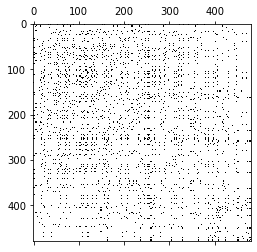

In [40]:
company_adjacency = squareform(np.where(company_distances > 0 , 1 , 0))
plt.spy(company_adjacency)
plt.show()

In [41]:
# Add labels for visualisation in Gephi

movie_companies_matrix['label'] = movie_companies_matrix.apply(lambda x: [company for company in companies if x[company] != 0], axis=1)
movie_companies_matrix['label'] = movie_companies_matrix.apply(lambda x: {0: '-'.join(x['label'])}, axis=1)
movie_companies_matrix['label']

0      {0: 'Lightstorm Entertainment-Paramount Pictur...
1      {0: 'Davis Entertainment-Gordon Company-Licht/...
2      {0: 'PolyGram Filmed Entertainment-Warner Bros.'}
3              {0: 'Pacific Western-Universal Pictures'}
4                                 {0: 'Eon Productions'}
                             ...                        
475    {0: 'Independent Pictures (II)-Miramax Films-T...
476                                 {0: 'Miramax Films'}
477                      {0: 'Fox Searchlight Pictures'}
478          {0: 'Miramax Films-View Askew Productions'}
479    {0: 'Alliance Atlantis Communications-Fair and...
Name: label, Length: 480, dtype: object

In [42]:
graph = nx.from_numpy_array(company_adjacency)
nx.set_node_attributes(graph, movie_companies_matrix['label'])
nx.write_gexf(graph, GRAPH_PATH+'movie_companies.gexf')

## Combining feature networks

In [69]:
np.histogram(genre_distances)

(array([   46,   326,  1637,  5906, 14226, 23458, 26272, 21439, 13624,
         8026], dtype=int64),
 array([0.42105263, 0.47894737, 0.53684211, 0.59473684, 0.65263158,
        0.71052632, 0.76842105, 0.82631579, 0.88421053, 0.94210526,
        1.        ]))

In [72]:
np.histogram(keyword_distances)

(array([114386,    511,     32,      7,      5,      6,      0,      0,
             1,     12], dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [73]:
np.histogram(company_distances)

(array([108519,   1655,   1389,   1693,     28,   1179,     57,      0,
             0,    440], dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [198]:
genre_factor = 1
keyword_factor = 5
company_factor = 3
movie_distances = genre_factor*genre_distances + keyword_factor*keyword_distances + 

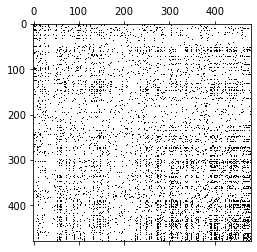

In [205]:
movie_adjacency = squareform(np.where(movie_distances > 0.9,1,0))
plt.spy(movie_adjacency)
plt.show()

In [208]:
pd.DataFrame(movie_adjacency).to_csv(GENERATED_PATH+"movie_features_adjacency.csv")

In [206]:
graph = nx.from_numpy_array(movie_adjacency)
#nx.set_node_attributes(graph, movie_keywords_matrix['label'])
nx.write_gexf(graph, GRAPH_PATH+'movie_features.gexf')